# COXTABL - Extension of the STABL algorithm 


In this notebook we will introduce the extension of the STABL algorithm to the Cox Proportional Hazard model. 

## Data preparation:

Plug your own data here. At the end of this section you should have two variables defined:
- `survival_df` - the table with the information about event (e.g., death), time to event (e.g., survival time), and features for the Cox model. Be sure that there are no NA values in this table.
- `BASE_SURVIVAL_COLUMNS` - the table with the Cox features used in the analysis.

In [1]:
import pandas


NB_OF_CELLOHOOD_CLUSTER = 36


full_survival_df = pandas.read_csv('../../tumorhood/tumorhood_bc/notebooks/Panel1_Cellohood_with_clinical.csv')
cn_counts = full_survival_df[[f'CN{i}' for i in range(NB_OF_CELLOHOOD_CLUSTER)] + ['immucan_id']].groupby('immucan_id').mean()
cn_counts.columns = [f'MCN{i}' for i in range(NB_OF_CELLOHOOD_CLUSTER)] 

base_survival_df = full_survival_df.groupby('immucan_id').first()
survival_df = pandas.merge(base_survival_df, cn_counts, on='immucan_id')

survival_df['is_squamous'] = survival_df['simple_histology'] == 'Squamous cell carcinoma'
survival_df['is_other'] = survival_df['simple_histology'].apply(
    lambda x: x not in ['Squamous cell carcinoma', 'Adenocarcinoma']
)


BASE_SURVIVAL_COLUMNS = [
    'stage_1',
    'stage_2',
    'stage_3',
    'stage_4',
    'is_adeno',
    'is_squamous',
    'is_other',
] + [f'MCN{i}' for i in range(NB_OF_CELLOHOOD_CLUSTER)]

## Running COXTABL on the df.

In this section we will run a lasso version of the COXTABL with artificial features created by permuting the original features. The main function used is `coxtabl.lasso_coxtabl_on_df` with parameters:
- `df` - dataframe with survival data,
- `event_col: str` column with the event indicator,
- `duration_col: str` time to event data,
- `data_cols: Optional[list]` name of the features to be used by the Cox model (by default all features, except `event_col` and `duration_col` are used,
- `l1s_to_check: Optional[list]` values of the L1 ratio used - by default `numpy.logspace(-1, -1.5, 10)` is used,
- `l2: float = 0.1` - value for the L2 regularization to impose the numerical stability,
- `iters: int = 100` - number of bootstrap iterations (minimal - 100, optimal > 1000)
- `bootstrap_sample: float = 0.5` - percentage of examples used for a single bootstrap iteration,
- `random_seed: int = 42` - random state for reproducibility,
- `standardize: bool = True` - flag that indicates if data fed to the Cox model is normally standardized,
- `permuted_prefix: str = 'ART'` - prefix of the artificially permuted columns,
- `cox_kwargs: Optional[dict] = None` - additional parameters fed to the `lifelines.CoxPHFitter` object constructor,
- `fit_kwargs: Optional[dict] = None` - additional parameters fed to the `lifelines.CoxPHFitter`  fit method.

It returns a named tuple `LassoCOXTABLResult` with fields:
- `CoxPHFitters` - all `lifelines.CoxPHFFitter` objects used in the experiment,
- `l1_to_names_to_coefs` - mapping from l1 values to values of the coefficients for every feature. E.g. `result.l1_to_names_to_coefs[0.1][feature]` will return values of the learned coefficients for `feature` obtained in training with `0.1` L1 rate,
- `data_cols` - feature names used in the experiment,
- `artificial_cols` - names of the artificially created features.

In [2]:
from coxtabl import coxtabl


lasso_result = coxtabl.lasso_coxtabl_on_df(
    survival_df, 
    data_cols=BASE_SURVIVAL_COLUMNS,
    iters=10,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.40s/it]


## Computation of the F-acceptance matrix.

Part of the `STABL` algorithm is computation of the non-zero parameter percentage for different values of regularization. You can use `coxtabl.compute_acceptance_per_l1_df` function that accepts as its input:
- `result: LassoCOXTABLResult` - result of a `coxtabl.lasso_coxtabl_on_df` function,
- `threshold: float = 0.01` - coefficients with absolute value smaller than `threshold` are treated as zero-valued coefficients. 

One can use `coxtabl.plot_acceptance_matrix` to plot the acceptance matrix in a digestible format.

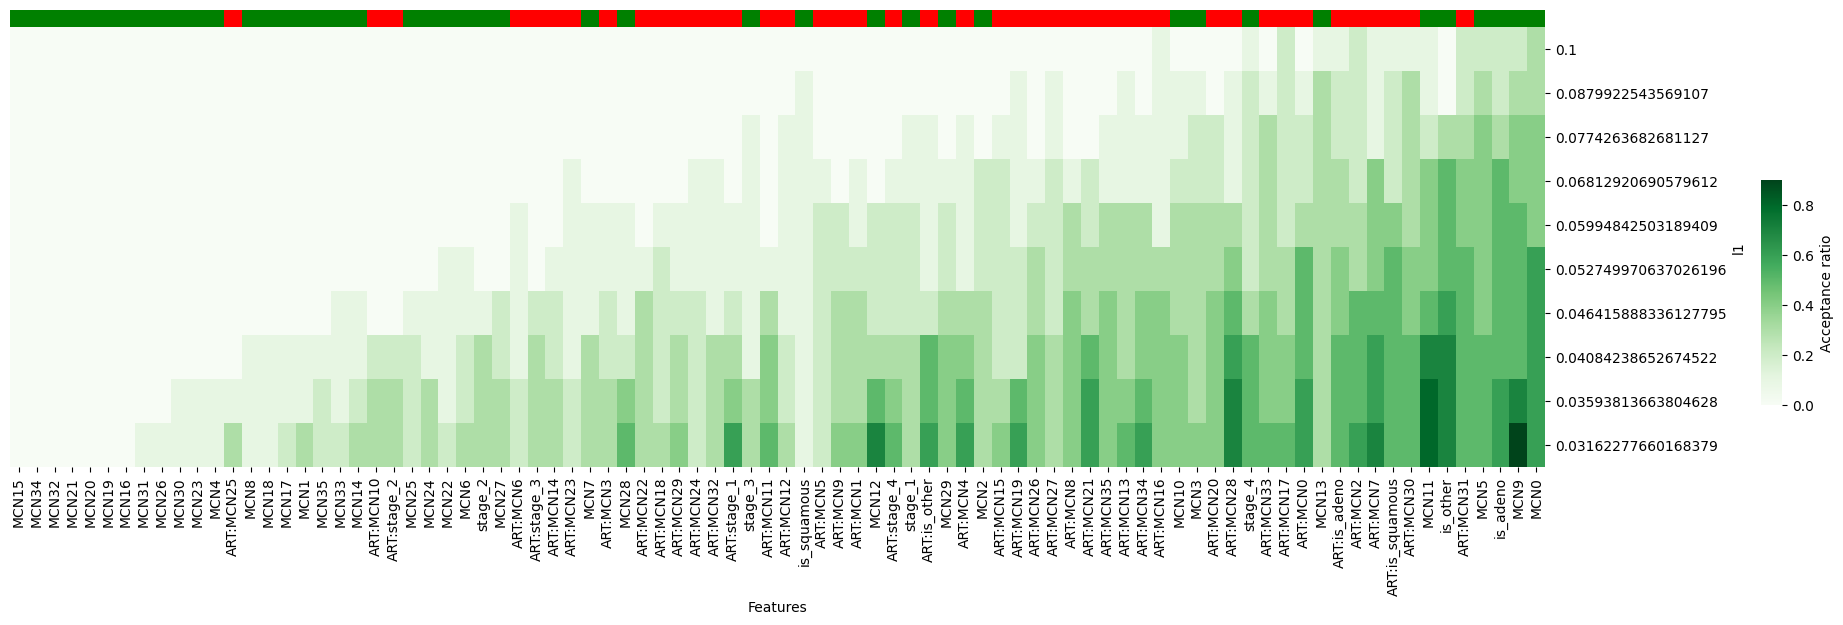

In [3]:
acceptance_per_l1_df = coxtabl.compute_acceptance_per_l1_df(lasso_result, threshold=0.01)
coxtabl.plot_acceptance_matrix(acceptance_per_l1_df)

## Feature selection.

Acceptance matrix is used for a final feature selection. It is performed using `coxtabl.feature_selection` method.

It returns a named tuple `FeatureSelectionResult` with,
- `thresholds` - thresholds used in the analysis,
- `fdps` - FDPs computed as a part of STABL algorithm,
- `threshold` - threshold for a minimal FDP,
- `selected_features` - list of a finally selected features.

In [4]:
feature_selection_result = coxtabl.feature_selection(
    acceptance_per_l1_df,
    data_cols=lasso_result.data_cols,
    artificial_cols=lasso_result.artificial_cols,
)

feature_selection_result.selected_features

Index(['stage_4', 'is_adeno', 'is_other', 'MCN0', 'MCN3', 'MCN5', 'MCN9',
       'MCN10', 'MCN11', 'MCN12', 'MCN28', 'MCN29'],
      dtype='object', name='Features')

One can use a handy `coxtable.plot_feature_selection_result` function to visualize results:

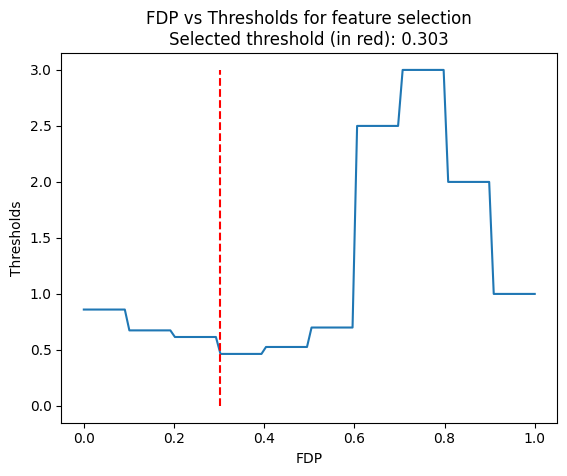

In [5]:
coxtabl.plot_feature_selection_result(feature_selection_result)

In [6]:
!pip freeze > ../requirements.txt